In [1]:
#create config
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 256  # TODO: the generated image resolution
    channels = 1
    train_batch_size = 4 # 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 600
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 30
    save_model_epochs = 300
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "lesion-filling-256"  # the model name locally and on the HF Hub
    dataset_path = "./dataset/imgs"
    segm_path = "./dataset/segm"
    pretrained_path = "./pretrained"
    num_gpu=2
    #uniform_dataset_path = "./uniform_dataset"

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    #hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    #hub_private_repo = False
    #overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0
config = TrainingConfig()

In [2]:
#setup tensorboard
import torch 

In [3]:
# create dataset
from torch.utils.data import Dataset
from torch.nn import functional as F
from pathlib import Path
import nibabel as nib
import numpy as np
from math import floor, ceil

class Dataset_Training(Dataset):
    """
    Dataset for Training purposes. 
    Adapted implementation of BraTS 2023 Inpainting Challenge (https://github.com/BraTS-inpainting/2023_challenge).
    
    Contains ground truth t1n images (gt) 
    Args:
        root_dir_img: Path to img files
        root_dir_segm: Path to segmentation maps
        pad_shape: Shape the images will be transformed to

    Raises:
        UserWarning: When your input images are not (256, 256, 160)

    Returns: 
        __getitem__: Returns a dictoinary containing:
            "gt_image": Padded and cropped version of t1n 2D slice
            "t1n_path": Path to the unpadded t1n file for this sample
            "max_v": Maximal value of t1 image (used for normalization) 
    """

    def __init__(self, root_dir_img: Path, root_dir_segm: Path, pad_shape=(256,256,256)):
        #Initialize variables
        self.root_dir_img = root_dir_img
        self.root_dir_segm = root_dir_segm
        self.pad_shape = pad_shape 
        self.list_paths_t1n = list(root_dir_img.rglob("*.nii.gz"))
        self.list_paths_segm = list(root_dir_segm.rglob("*.nii.gz"))
        #define offsets between first and last segmented slices and the slices to be used for training
        bottom_offset=60 
        top_offset=20

        #go through all 3D imgs
        idx=0
        self.idx_to_2D_slice = dict()
        for j, path in enumerate(self.list_paths_segm):
            t1n_segm = nib.load(path)
            t1n_3d = t1n_segm.get_fdata()

            #get first slice with segmented content and add offset
            i=0
            while(not t1n_3d[:,i,:].any()):
                i+=1
            bottom=i+bottom_offset

            #get last slice with segmented content and add offset
            i=t1n_3d.shape[1]-1
            while(not t1n_3d[:,i,:].any()):
                i-=1
            top=i-top_offset

            #Add all slices between desired top and bottom slice to dataset
            for i in np.arange(top-bottom):
                self.idx_to_2D_slice[idx]=(self.list_paths_t1n[j],bottom+i)
                idx+=1 

    def __len__(self): 
        return len(self.idx_to_2D_slice.keys()) 

    def preprocess(self, t1n: np.ndarray):
        """
        Transforms the images to a more unified format.
        Normalizes to -1,1. Pad and crop to bounding box.
        
        Args:
            t1n (np.ndarray): t1n from t1n file (ground truth).

        Raises:
            UserWarning: When your input images are not (256, 256, 160)

        Returns:
            t1n: The padded and cropped version of t1n.
            t1n_max_v: Maximal value of t1n image (used for normalization).
        """

        #Size assertions
        reference_shape = (256,256,160)
        if t1n.shape != reference_shape:
            raise UserWarning(f"Your t1n shape is not {reference_shape}, it is {t1n.shape}")

        #Normalize the image to [0,1]
        t1n[t1n<0] = 0 #Values below 0 are considered to be noise #TODO: Check validity
        t1n_max_v = np.max(t1n)
        t1n /= t1n_max_v

        #pad to bounding box
        size = self.pad_shape # shape of bounding box is (size,size,size) #TODO: Find solution for 2D
        t1n = torch.Tensor(t1n)
        d, w, h = t1n.shape[-3], t1n.shape[-2], t1n.shape[-1]
        d_max, w_max, h_max = size
        d_pad = max((d_max - d) / 2, 0)
        w_pad = max((w_max - w) / 2, 0)
        h_pad = max((h_max - h) / 2, 0)
        padding = (
            int(floor(h_pad)),
            int(ceil(h_pad)),
            int(floor(w_pad)),
            int(ceil(w_pad)),
            int(floor(d_pad)),
            int(ceil(d_pad)),
        )
        t1n = F.pad(t1n, padding, value=0, mode="constant") 

        #map images from [0,1] to [-1,1]
        t1n = (t1n*2) - 1

        return t1n, t1n_max_v

    def __getitem__(self, idx):
        t1n_path = self.idx_to_2D_slice[idx][0]
        slice_idx = self.idx_to_2D_slice[idx][1]
        t1n_img = nib.load(t1n_path)
        t1n = t1n_img.get_fdata()
        
        # preprocess data
        t1n, t1n_max_v = self.preprocess(t1n) # around 0.2s on local machine
        
        # get 2D slice from 3D
        t1n_slice = t1n[:,slice_idx,:] 
        
        # Output data
        sample_dict = {
            "gt_image": t1n_slice.unsqueeze(0),
            "t1n_path": str(t1n_path),  # path to the 3D t1n file for this sample.
            "max_v": t1n_max_v,  # maximal t1n_voided value used for normalization 
        }
        return sample_dict 

In [4]:
#create dataset
datasetTrain = Dataset_Training(Path(config.dataset_path), Path(config.segm_path), pad_shape=(256, 256, 256)) # TODO: check shape

print(f"Dataset size: {len(datasetTrain)}")
print(f"\tImage shape: {datasetTrain[0]['gt_image'].shape}")
print(f"Training Data: {list(datasetTrain[0].keys())}") 

Dataset size: 1080
	Image shape: torch.Size([1, 256, 256])
Training Data: ['gt_image', 't1n_path', 'max_v']


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# load model
from diffusers import DDIMPipeline
from diffusers import UNet2DModel

pipe = DDIMPipeline.from_pretrained(config.pretrained_path)
model=pipe.unet
model.to(device)

/opt/conda/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/opt/conda/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


UNet2DModel(
  (conv_in): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): LoRACompatibleLinear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): LoRACompatibleConv(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsampl

### RePaint Inpainting

In [7]:
from diffusers import RePaintPipeline, RePaintScheduler 

rePaint = RePaintPipeline(unet=model, scheduler=RePaintScheduler())

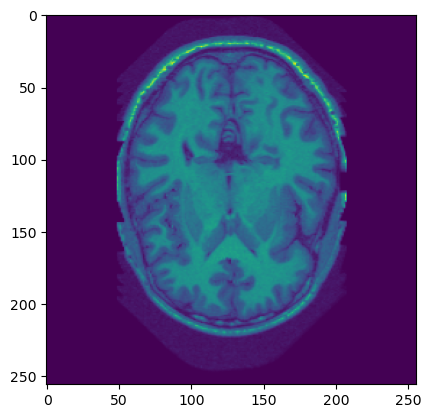

In [9]:
import matplotlib.pyplot as plt
img=datasetTrain[1]["gt_image"].squeeze()
plt.imshow((img+1)/2)

In [10]:
mask = torch.zeros_like(img)
mask[60:110, 110:150]=1

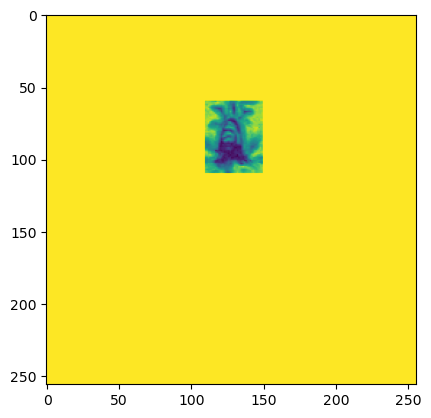

In [11]:
plt.imshow((img*mask+1)/2)

In [12]:
gen = torch.Generator()

In [13]:
img.to(device)
mask.to(device)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [14]:
inpainted_img = rePaint(img.unsqueeze(0).unsqueeze(0), mask, generator=gen, output_type="np.array")

/opt/conda/lib/python3.11/site-packages/diffusers/pipelines/deprecated/repaint/pipeline_repaint.py:35: FutureWarning: The preprocess method is deprecated and will be removed in diffusers 1.0.0. Please use VaeImageProcessor.preprocess(...) instead
  deprecate("preprocess", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/4570 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.imshow(inpainted_img.images[0].squeeze())
plt.savefig('inpainted_img.png')

In [15]:
#create python script for ubelix
!jupyter nbconvert --to script "lesion_filling_unconditioned_repaint.ipynb"

[NbConvertApp] Converting notebook lesion_filling_unconditioned_repaint.ipynb to script
[NbConvertApp] Writing 7184 bytes to lesion_filling_unconditioned_repaint.py
